# Data Dive 2

In [113]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

from wordcloud import WordCloud

# Run once then comment out, if necessary
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
# to get sentiment, do: sia.polarity_scores(STRING)
# which will return a dict with keys "neg", "neu", "pos", and "compound"

import seaborn as sns


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nicksartino/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [131]:
print(nltk.__version__)

3.8.1


In [114]:
df= pd.read_csv('credit_card_complaints.csv')

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17433 entries, 0 to 17432
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   date_received                 17433 non-null  int64  
 1   product                       17433 non-null  object 
 2   sub_product                   0 non-null      float64
 3   issue                         17433 non-null  object 
 4   sub_issue                     0 non-null      float64
 5   consumer_complaint_narrative  17433 non-null  object 
 6   company_public_response       8963 non-null   object 
 7   company                       17433 non-null  object 
 8   state                         17379 non-null  object 
 9   zip_code                      17379 non-null  object 
 10  tags                          2808 non-null   object 
 11  consumer_consent_provided     17433 non-null  object 
 12  submitted_via                 17433 non-null  object 
 13  d

In [116]:
df.describe()

,date_received,sub_product,sub_issue,date_sent_to_company,complaint_id
count,17433.000000,0.0,0.0,17433.000000,1.743300e+04
mean,42463.076866,NaN,NaN,42464.511329,1.864532e+06
std,207.296686,NaN,NaN,207.430956,3.117701e+05
min,42082.000000,NaN,NaN,42082.000000,1.290323e+06
25%,42285.000000,NaN,NaN,42285.000000,1.598380e+06
50%,42474.000000,NaN,NaN,42475.000000,1.879286e+06
75%,42643.000000,NaN,NaN,42644.000000,2.139726e+06
max,42829.000000,NaN,NaN,42829.000000,2.418474e+06


In [117]:
df.head(100)

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zip_code,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,complaint_id
0,42431,Credit card,NaN,Identity theft / Fraud / Embezzlement,NaN,- I am being pursued by U S Bank for fraudulen...,Company has responded to the consumer and the ...,U.S. Bancorp,AL,352XX,NaN,Consent provided,Web,42431,Closed with non-monetary relief,True,False,1813752
1,42694,Credit card,NaN,Rewards,NaN,- I opened an Amex credit card account in XXXX...,NaN,Amex,VA,231XX,NaN,Consent provided,Web,42695,Closed with non-monetary relief,True,True,2216897
2,42139,Credit card,NaN,Billing disputes,NaN,-- -- -- -- -- Forwarded message -- -- -- -- -...,NaN,Capital One,CA,920XX,NaN,Consent provided,Web,42143,Closed with explanation,True,True,1378763
3,42155,Credit card,NaN,Other fee,NaN,-- Price gauging with foreign transaction fees...,Company chooses not to provide a public response,Bank of America,NaN,NaN,NaN,Consent provided,Web,42155,Closed with monetary relief,True,False,1399288
4,42631,Credit card,NaN,Rewards,NaN,-I have filed a claim already and American Exp...,NaN,Amex,CO,805XX,NaN,Consent provided,Web,42631,Closed with non-monetary relief,True,False,2117687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,42094,Credit card,NaN,Billing disputes,NaN,30 day late payment assessed. Payment sent XXX...,Company chooses not to provide a public response,Synovus Bank,FL,328XX,NaN,Consent provided,Web,42094,Closed with non-monetary relief,True,True,1307908
96,42573,Credit card,NaN,Credit determination,NaN,30 days past.response not received. \nPlease r...,NaN,Capital One,CA,915XX,NaN,Consent provided,Web,42573,Closed with explanation,True,False,2024334
97,42360,Credit card,NaN,Identity theft / Fraud / Embezzlement,NaN,5th 3rd bank and affiliates continue to harass...,NaN,Fifth Third Financial Corporation,FL,339XX,NaN,Consent provided,Web,42360,Closed with explanation,True,False,1710693
98,42481,Credit card,NaN,Billing disputes,NaN,A {$500.00} purchase had been disputed with Bl...,Company has responded to the consumer and the ...,Citibank,CA,921XX,NaN,Consent provided,Web,42481,Closed with monetary relief,True,False,1889919


# What Questions are We Trying to Ask
* Company response vs various types of issues
* Most Hated company?
* Most Liked (heuristics)
* Sentiment analysis (maybe)
* Monetary compensation paid to unhappy customers

In [118]:
grouped = df.groupby('company_public_response')
grouped_count = grouped.size()
print(grouped_count)

company_public_response
Company believes complaint caused principally by actions of third party outside the control or direction of the company      10
Company believes complaint is the result of an isolated error                                                                54
Company believes complaint relates to a discontinued policy or procedure                                                      1
Company believes complaint represents an opportunity for improvement to better serve consumers                               17
Company believes it acted appropriately as authorized by contract or law                                                    372
Company believes the complaint is the result of a misunderstanding                                                           19
Company can't verify or dispute the facts in the complaint                                                                   11
Company chooses not to provide a public response                                

In [119]:
grouped_issue = df.groupby('issue')
grouped_issue_count = grouped_issue.size()
print(grouped_issue_count) 

issue
APR or interest rate                         741
Advertising and marketing                    771
Application processing delay                  91
Arbitration                                   72
Balance transfer                             280
Balance transfer fee                          49
Bankruptcy                                    90
Billing disputes                            2800
Billing statement                            587
Cash advance                                  43
Cash advance fee                              40
Closing/Cancelling account                  1341
Convenience checks                            32
Credit card protection / Debt protection     660
Credit determination                         485
Credit line increase/decrease                416
Customer service / Customer relations        903
Delinquent account                           776
Forbearance / Workout plans                   79
Identity theft / Fraud / Embezzlement       1602
Late fee      

In [120]:
grouped = df.groupby('company')
grouped_count = grouped.size()
grouped_sum = grouped['complaint_id'].sum()
print(grouped_count)
print(grouped_sum)

company
APPLE RECOVERY, LLC              1
ARS National Services, Inc.      1
Acceptance Rentals, Inc.         1
Adir International, LLC          1
Affiliates Management Company    1
                                ..
Weltman, Weinberg & Reis         1
Whitney Bank                     1
ZENCO COLLECTION, LLC            1
Zions Bancorporation             1
Zwicker & Associates             1
Length: 205, dtype: int64
company
APPLE RECOVERY, LLC              1737384
ARS National Services, Inc.      2117648
Acceptance Rentals, Inc.         2186321
Adir International, LLC          1417716
Affiliates Management Company    2279929
                                  ...   
Weltman, Weinberg & Reis         1935917
Whitney Bank                     2317135
ZENCO COLLECTION, LLC            2101805
Zions Bancorporation             1315981
Zwicker & Associates             1934257
Name: complaint_id, Length: 205, dtype: int64


In [121]:
# sentiment_df = df.apply(lambda row: sia.polarity_scores(row["consumer_complaint_narrative"]), axis='rows')
#df["consumer_complaint_narrative"].apply(lambda val : sia.polarity_scores(val)["neg"])

In [122]:
df['consumer_complaint_score'] = df["consumer_complaint_narrative"].apply(lambda val : sia.polarity_scores(val)["neg"])

In [123]:
# Create 'new_date' column which is a floating point version of the string 'date_sent_to_company'

df['new_date'] = df['date_sent_to_company'].apply(float)

# This loop is used to create a Pandas timestamp from the excel formatted date from the data.  We are using an older version of Pandas so the method for each row is using the previously created float date as an offset that gets added to the date '1899-12-30' 

excel_dates = []

for row in df['new_date']:
    pandas_date = pd.to_datetime('1899-12-30') + pd.DateOffset(days=row)
    excel_dates.append(pandas_date)
df['excel_date'] = excel_dates
df = df.drop('new_date',axis=1)

df.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zip_code,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,complaint_id,consumer_complaint_score,excel_date
0,42431,Credit card,NaN,Identity theft / Fraud / Embezzlement,NaN,- I am being pursued by U S Bank for fraudulen...,Company has responded to the consumer and the ...,U.S. Bancorp,AL,352XX,NaN,Consent provided,Web,42431,Closed with non-monetary relief,True,False,1813752,0.171,2016-03-02
1,42694,Credit card,NaN,Rewards,NaN,- I opened an Amex credit card account in XXXX...,NaN,Amex,VA,231XX,NaN,Consent provided,Web,42695,Closed with non-monetary relief,True,True,2216897,0.033,2016-11-21
2,42139,Credit card,NaN,Billing disputes,NaN,-- -- -- -- -- Forwarded message -- -- -- -- -...,NaN,Capital One,CA,920XX,NaN,Consent provided,Web,42143,Closed with explanation,True,True,1378763,0.100,2015-05-19
3,42155,Credit card,NaN,Other fee,NaN,-- Price gauging with foreign transaction fees...,Company chooses not to provide a public response,Bank of America,NaN,NaN,NaN,Consent provided,Web,42155,Closed with monetary relief,True,False,1399288,0.036,2015-05-31
4,42631,Credit card,NaN,Rewards,NaN,-I have filed a claim already and American Exp...,NaN,Amex,CO,805XX,NaN,Consent provided,Web,42631,Closed with non-monetary relief,True,False,2117687,0.041,2016-09-18


In [124]:
# Create Month column for grouping

months = []

for index, row in df.iterrows():
    month = row['excel_date'].month
    months.append(month)
    
df['month'] = months
df.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zip_code,...,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,complaint_id,consumer_complaint_score,excel_date,month
0,42431,Credit card,NaN,Identity theft / Fraud / Embezzlement,NaN,- I am being pursued by U S Bank for fraudulen...,Company has responded to the consumer and the ...,U.S. Bancorp,AL,352XX,...,Consent provided,Web,42431,Closed with non-monetary relief,True,False,1813752,0.171,2016-03-02,3
1,42694,Credit card,NaN,Rewards,NaN,- I opened an Amex credit card account in XXXX...,NaN,Amex,VA,231XX,...,Consent provided,Web,42695,Closed with non-monetary relief,True,True,2216897,0.033,2016-11-21,11
2,42139,Credit card,NaN,Billing disputes,NaN,-- -- -- -- -- Forwarded message -- -- -- -- -...,NaN,Capital One,CA,920XX,...,Consent provided,Web,42143,Closed with explanation,True,True,1378763,0.100,2015-05-19,5
3,42155,Credit card,NaN,Other fee,NaN,-- Price gauging with foreign transaction fees...,Company chooses not to provide a public response,Bank of America,NaN,NaN,...,Consent provided,Web,42155,Closed with monetary relief,True,False,1399288,0.036,2015-05-31,5
4,42631,Credit card,NaN,Rewards,NaN,-I have filed a claim already and American Exp...,NaN,Amex,CO,805XX,...,Consent provided,Web,42631,Closed with non-monetary relief,True,False,2117687,0.041,2016-09-18,9


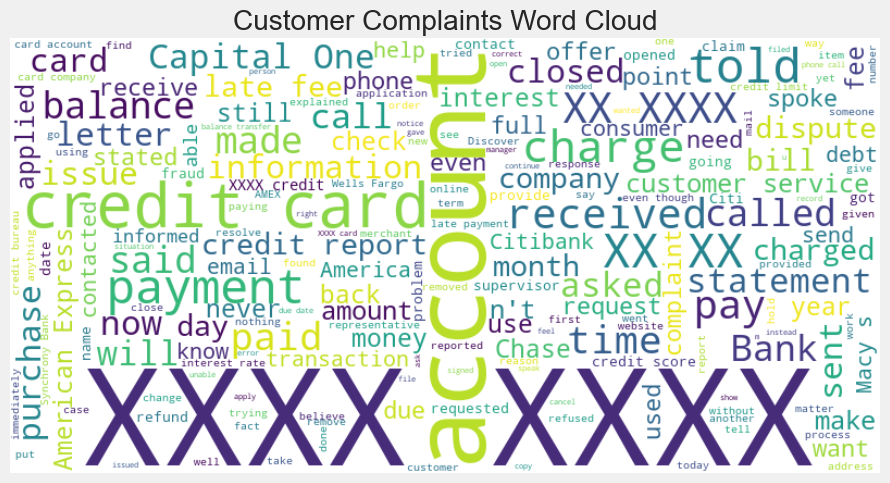

In [125]:
# Word Map of customer complaints

text = " ".join(complaint for complaint in df['consumer_complaint_narrative'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Customer Complaints Word Cloud")
plt.show()

In [134]:
# Create new dataframe for scatterplot

# Need count of complaints on x axis, consumer sentiment on y axis, and count of issues as size

new_data = {
    'average_sentiment':df.groupby('company')['consumer_complaint_score'].mean(),
    'issue_count':df.groupby('company')['issue'].count(),
    'company_response_count':df.groupby('company')['company_response_to_consumer'].count()
}

df_scatter = pd.DataFrame(new_data)
df_scatter = df_scatter.reset_index()

# Filter to reduce company count
filtered_scatter = df_scatter[df_scatter['issue_count'] >= 100]
# Sort descending
sorted_df = filtered_scatter.sort_values(by='issue_count',ascending=False)
sorted_df.head(100)

,company,average_sentiment,issue_count,company_response_count
44,Citibank,0.078550,3731,3731
38,Capital One,0.078815,2078,2078
177,Synchrony Financial,0.074702,1851,1851
110,JPMorgan Chase & Co.,0.079507,1846,1846
27,Bank of America,0.080841,1443,1443
11,Amex,0.072959,1358,1358
29,Barclays PLC,0.077759,838,838
64,Discover,0.081406,781,781
199,Wells Fargo & Company,0.072444,676,676
189,U.S. Bancorp,0.065677,606,606


/Users/nicksartino/anaconda3/envs/Jupyter/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


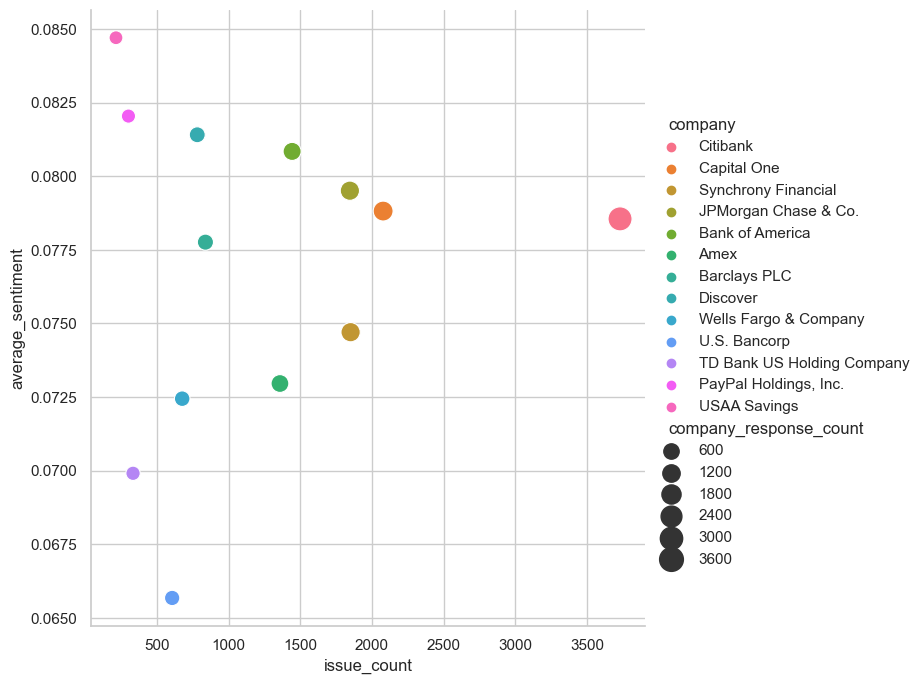

In [135]:
# Scatterplot with varying sizes

sns.set(style='whitegrid')
sns.relplot(x='issue_count',y='average_sentiment', hue='company', size='company_response_count',
            sizes=(100,300), alpha=1,
            height=7, data=sorted_df)

In [136]:
# Create the average sentiment over each month dataframe

top_10_data = {
    'company':df['company'],
    'average_sentiment':df['consumer_complaint_score'],
    'month':df['month']
}

df_top10 = pd.DataFrame(top_10_data)
df_top10.head(100)




,company,average_sentiment,month
0,U.S. Bancorp,0.171,3
1,Amex,0.033,11
2,Capital One,0.100,5
3,Bank of America,0.036,5
4,Amex,0.041,9
...,...,...,...
95,Synovus Bank,0.000,3
96,Capital One,0.135,7
97,Fifth Third Financial Corporation,0.146,12
98,Citibank,0.097,4


In [129]:
# Group the DataFrame by 'company' and 'excel_date' to calculate the average sentiment by month
company_monthly_sentiment = df_top10.groupby(['company', df_top10['month']])['average_sentiment'].mean().reset_index()

# Sort the DataFrame by 'average_sentiment' in ascending order
company_monthly_sentiment = company_monthly_sentiment.sort_values(by='average_sentiment')

# Filter for rows where 'average_sentiment_by_month' > 0
monthly_avg_sentiment = company_monthly_sentiment[company_monthly_sentiment['average_sentiment'] > 0]

# Sort and filter for the top 10 companies with the lowest average sentiment by month
top_10_lowest_avg_sentiment = monthly_avg_sentiment.sort_values('average_sentiment').head(100)
top_10_lowest_avg_sentiment.head(100)

,company,month,average_sentiment
564,SchoolsFirst Federal Credit Union,11,0.005
583,Sterling Jewelers Inc.,4,0.013
409,KeyCorp,9,0.014
2,"Acceptance Rentals, Inc.",1,0.014
503,People's United Bank,5,0.015
...,...,...,...
343,First Tennessee Bank,4,0.046
135,"CL Holdings, LLC",10,0.046
64,BB&T Financial,12,0.046
561,Santander Consumer USA Holdings Inc,3,0.046


<Axes: xlabel='month', ylabel='average_sentiment'>

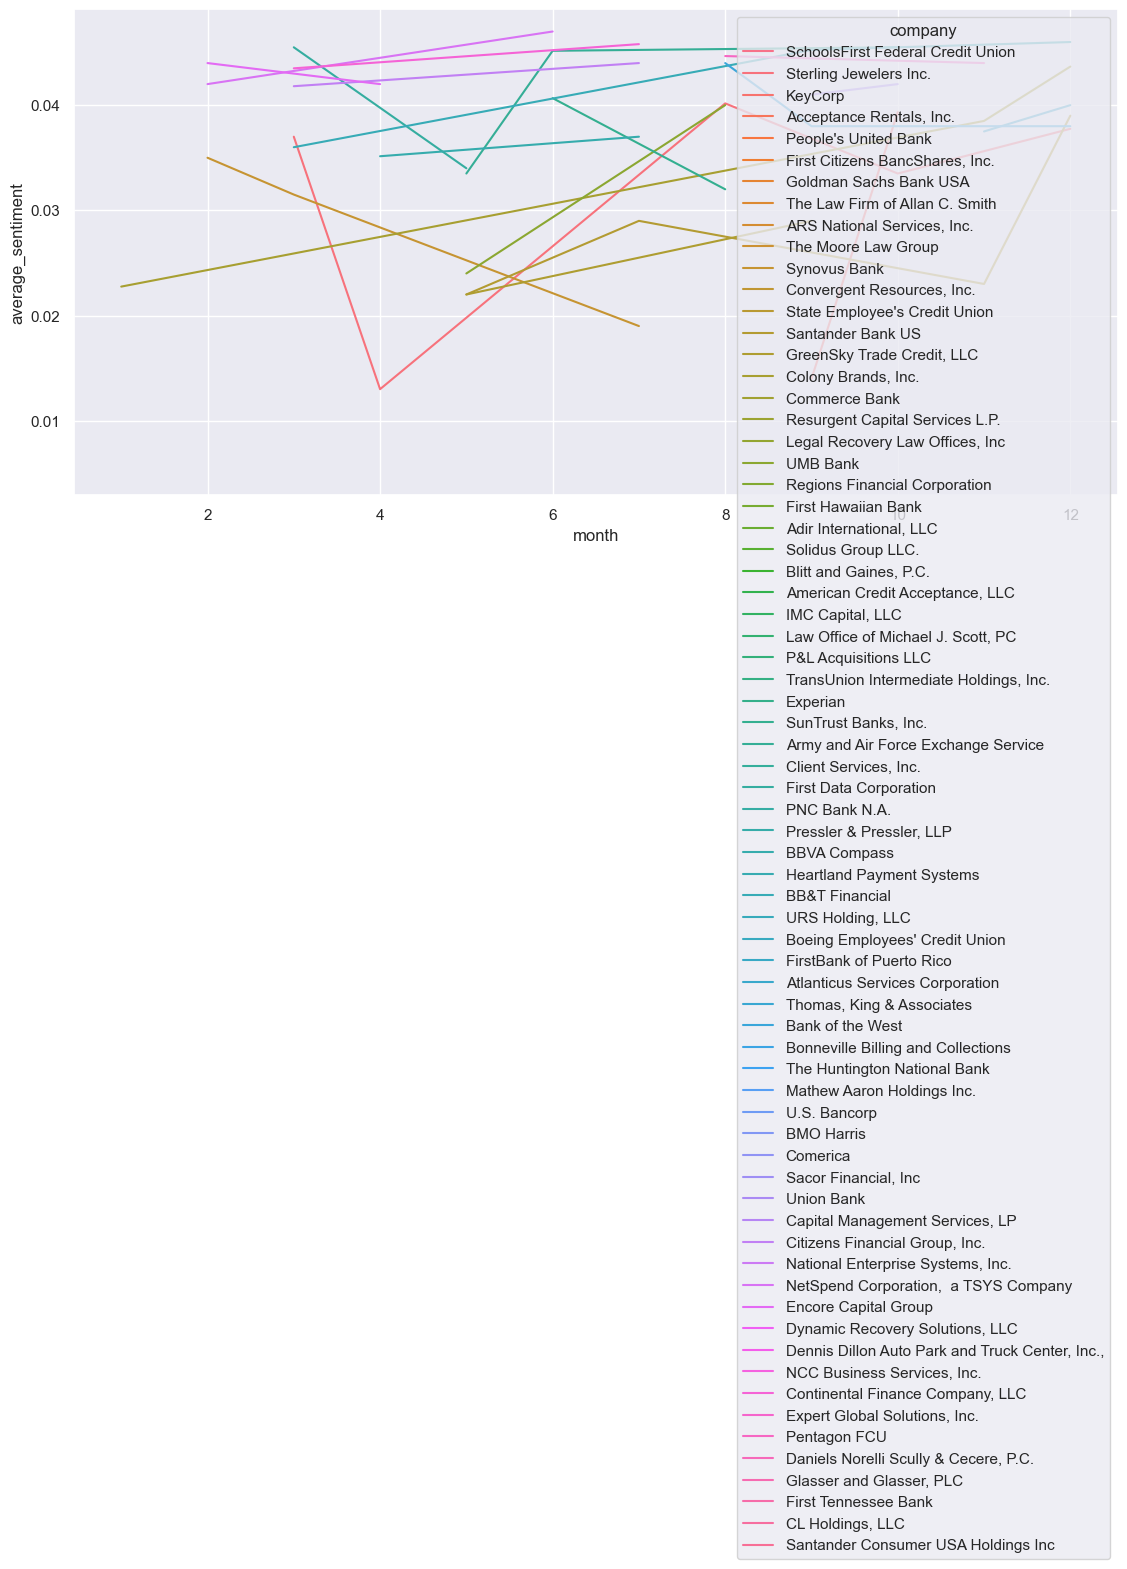

In [130]:
# Plot sentiment over excel date column
sns.set_theme(style='darkgrid')
plt.figure(figsize=(12,6))
sns.lineplot(x='month', y='average_sentiment', hue='company',data=top_10_lowest_avg_sentiment)

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17433 entries, 0 to 17432
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   date_received                 17433 non-null  int64         
 1   product                       17433 non-null  object        
 2   sub_product                   0 non-null      float64       
 3   issue                         17433 non-null  object        
 4   sub_issue                     0 non-null      float64       
 5   consumer_complaint_narrative  17433 non-null  object        
 6   company_public_response       8963 non-null   object        
 7   company                       17433 non-null  object        
 8   state                         17379 non-null  object        
 9   zip_code                      17379 non-null  object        
 10  tags                          2808 non-null   object        
 11  consumer_consent_provided   